# Big Data Analytics Group Project
 by Xiaozhe Yao（19-759-570）& Yingying Chen（19-759-588）

 > In this project, we manually collected twitter data with the hastag #COVID-19 from April to June. Then we perform sentiment analysis on each tweet, and predict its emotion by using natural language processing techniques. In our pipeline, we first analysed the polarity and subjectivity of each tweet, and then predict the emotion in six metrics: happy, bad, encouraged, joy, loving, and depressed. Besides of these, we also build a binary classifier to find out if a tweet is insult speech. There are five hundred thousands tweets per day approximately and 9,841,743 in total (until the submission), to properly handle them, we indeed build a cluster with four nodes to process the tweets everyday. In this notebook, we will provide the demo code to perform all the tasks that we have, and we will also describe how the system works on our cluster. The complete code for the running system is archived in the attached file. Our visualization result are also available online at https://covid19.yaonotes.org. There's also a short introduction on why we want to make this site (on the right upper corner). This notebook was tested with Google Colab. All data are avaliable at Google Drive:https://drive.google.com/drive/folders/1g1ZqcZ3xRtDKrR3aIl1bLs2vzetCa0g0?usp=sharing. Codes for the system and website can also be accessed at Github: https://github.com/xzyaoi/covid-sentiment.

![ChessUrl](https://raw.githubusercontent.com/xzyaoi/covid-sentiment/master/ezgif.com-gif-maker.gif "full-visualizer")


This notebook will be organized into the following parts:

* **Dependencies Installation**. In this code block, we will declare all our dependencies and provide code to install them.

* **Data Crawling.** We will use a small timeframe (~20 minutes of the day when the code is being run) and then crawl all tweets during that timeframe. It will be saved to a ```.csv``` file as well as a python pandas dataframe.

* **Data Exploration.** We will play around with the sample data we have crawled in step 2 and demonstrate what is included in the dataset.

* **Build Sentiment Analyser.** In this part, we will do three things. 1) we will use an existing library, the TextBlob, to predict the polarity and subjectivity. 2) we will use a neural network to estimate the emotions of a text. 3) we will use another neural network to detect insult speech.

* **Sentiment Analysis.** In this part, we will demonstrate how we actually perform the prediction on our dataset. We use the apply function in pandas, and make it parallel to improve the speed. We also draw the wordcloud as background.

* **Data Collection and Merging.** We then collect the result, and resample the granularity to minute-level.

* **Data Visualization.** In this part, we will  visualize the result into a line chart to demonstrate the changes in people's emotion during the pandemic.

* **Data Warehouse.** We will talk about how we store the data in our data warehouse.

* **Conclusion and Discussion.** In this part, we will discuss the results that we have in the visualization and exploration part. We will conclude how people's emotion change during the time period.

* **Implementation, Limitations and Possible Improvements.** We will introduce how we actually implement this in our cluster, the limitations and possible improvements.

## Dependencies Installation

In [0]:
## Python Packages
!pip install twint
!pip install mlpm
!pip install tensorflow
!pip install keras
!pip install pandas==1.0.4
!pip install deeppavlov
!pip install pandarallel
!pip install tqdm
!pip install seaborn
!pip install wordcloud
## NOTICE: You may need to restart the notebook runtime, as the version of pandas may need to change.

In [0]:
## Files needed
!wget https://github.com/aidmodels/sentiment-analysis/releases/download/v0.1/model.h5 -O sentiment.h5
!wget https://raw.githubusercontent.com/aidmodels/sentiment-analysis/master/pretrained/tokenizer.pickle -O tokenizer.pickle
!wget https://raw.githubusercontent.com/deepmipt/DeepPavlov/0.10.0/deeppavlov/configs/classifiers/insults_kaggle_conv_bert.json

In [0]:
!python -m deeppavlov install squad_bert

In [0]:
## Change links in configuration file to github address, this is because the original server is too slow.
!sed -i 's,http://files.deeppavlov.ai/datasets/insults_data.tar.gz,https://github.com/aidmodels/insult_detection/releases/download/v0.1/insults_data.tar.gz,g' ./insults_kaggle_conv_bert.json
!sed -i 's,http://files.deeppavlov.ai/deeppavlov_data/bert/conversational_cased_L-12_H-768_A-12.tar.gz,https://github.com/aidmodels/insult_detection/releases/download/v0.1/conversational_cased_L-12_H-768_A-12.tar.gz,g' ./insults_kaggle_conv_bert.json
!sed -i 's,http://files.deeppavlov.ai/deeppavlov_data/classifiers/insults_kaggle_v4.tar.gz,https://github.com/aidmodels/insult_detection/releases/download/v0.1/insults_kaggle_v4.tar.gz,g' ./insults_kaggle_conv_bert.json

In [0]:
# This is only for Google Cloud Platform to boost the inference performance.
# If TPU is available, then use TPU.
import tensorflow as tf
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime.')

if tpu:
  print("I am using TPU")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Data Crawling
In our project, we want to get access to social media which contain a lot of public variable data. To obtain this information, we can typically get them via rate-limited APIs by company or scrap data from website. We tried to apply for a Twitter Developer account but got rejected, and as a result, we have to find libraries that do not require Twitter Developer account. In this project, we use the [Twint project](https://github.com/twintproject/twint) to crawl data from twitter. It is a Twitter scraping tool that does not use Twitter's API (more precisely, by mimicking a real user's behavior). 


We set the parameters in Twint so that it will only crawl data in a certain time period, and it will save the id of tweets in a session file, so that if there's any outage in the network connection occurs, we can safely resume the crawling.

Though the project can crawl *34* different properties of tweets, we only need several of them: *id*, *date*, *time*, *tweet*, *retweets_count*, *likes_count*. 

Here in this notebook, we only crawl a small amount of data, in the period of *2020-04-14 00:00:00* to *2020-04-14 00:30:00*. It should take around 10 minutes to finish. We also provide a single ```.csv``` file to download, so that you can directly import it into a pandas dataframe without any crawling.


In [0]:
# Data Crawling
## Get current date
import twint
import datetime

# Fetch data in a example data frame: 2020-04-14 00:00:00 to 2020-04-14 00:30:00

start_time='2020-04-14 00:00:00'
end_time='2020-04-14 00:30:00'

c = twint.Config()
c.Search = "#covid-19"
c.Lang="en"
c.Since= start_time
c.Until= end_time
c.Pandas = True
c.Store_csv = True
c.Retries_count = 20
c.Custom["tweet"] = ["id", "date", "time", "tweet", "retweets_count", "likes_count"]
c.Resume = "./test.session"
c.Output = "./test.csv"
twint.run.Search(c)

## Data Exploration

In this section, we will perform some basic data exploration about the data we have. Current, we are not able to do much, as we only have two key properties that we are interested: the retweets_count and likes_count. 

After we get the sentiment data, we will perform a deeper exploration. We will have more important metrics over there.

In [0]:
# If you do not want to crawling the data again, use this code block to download a sample. 
## It is the data crawled in 2020-04-14 00:00:00 to 2020-04-14 00:30:00
!wget https://raw.githubusercontent.com/CConstance/tweets_sentiment/master/test.csv

count         5352
unique        1664
top       00:00:00
freq            50
Name: time, dtype: object
count    5352.000000
mean        4.067638
std        75.366198
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      4406.000000
Name: retweets_count, dtype: float64


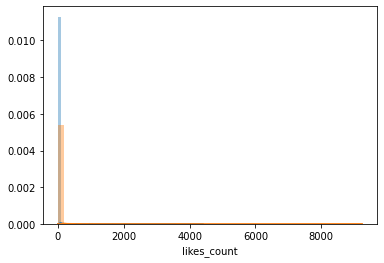

In [0]:
# Data Exploration and cleaning
# Take a look at origin crawling data
import pandas as pd
import seaborn as sns
df = pd.read_csv("test.csv")
df.head()
# check the decoration
df.columns
# descriptive statistics summary
print(df['time'].describe())

print(df['retweets_count'].describe())
## Here we found that most tweets do not have any retweets, while the maximum retweets_count is 4406.
sns.distplot(df['retweets_count']);
df['likes_count'].describe()
sns.distplot(df['likes_count']);
## Here we found that most tweets do not have any likes, while the maximum likes_count is 9238.
## The histogram and descriptive summary is the same with our intuition about twitter: 
## Most tweets do not get any feedback, while some KOLs (Key Opinion Leader) get more attentions and interactions.

In original crawling data, they have 34 colunms of items. During our sentiment analysis, we want to analyse the emotion from tweets for a period of time. Thus, we need to crawl tweets every day. It has several hundreds of thousand of tweets per day. To reduce the amount of fetched data, we filtered irrelvant items and left id, tweets and time while fetching data. ID is used to track the source of tweet. The content of tweet is used to analyse the emotion of users. Time records the changes of emotion.

Even though most tweets do not get any responses, it is still worth investigating them as they are reflecting the feelings and emotions of people at that time.

## Build Sentiment Analyser

In this section, we will build and test three sentiment analysers. They are of different metrics:

* **Emotion Recognition.** We have build a neural-network-based emotion extractor before, and will use the algorithm to extract emotion information from tweets. It will give 6 emotions: bad, depressed, encouraged, happy, joy, sad, loving. The output of every emotion is a real value ranged in $[0,1]$. The neural network architecture and corresponding training code will be provided as appendix.

* **Polarity and Subjectivity.** We will use [TextBlob](https://textblob.readthedocs.io/en/dev/) to analyse the polarity and subjectivity of a single sentence. It is a prebuilt library that uses NaiveBayes classifier to classify the input sentences.

* **Insultation.** We will use [DeepPavlov](http://docs.deeppavlov.ai/en/master/features/models/classifiers.html) to find out if a sentence includes insult content. It is also a neural-network based text classifier.

In [0]:
# Sentiment Analysis
## We use an existing neural network to perform sentiment analysis, in this notebook, we will present how it works.
## Inside our system, we deployed the neural network into a http server, and perform http requests to get the prediction.

from mlpm.solver import Solver
import pickle
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN=140

class SentimentSolver(Solver):
    def __init__(self, toml_file=None):
        super().__init__(toml_file)
        # Do you Init Work here
        with open('./tokenizer.pickle', 'rb') as handle:
            self.loaded_tokenizer = pickle.load(handle)
        self.model = tf.keras.models.load_model("./sentiment.h5")
        self.ready()

    def infer(self, data):
        # if you need to get file uploaded, get the path from input_file_path in data
        sequences = self.loaded_tokenizer.texts_to_sequences([data['text']])
        padding = pad_sequences(sequences, maxlen=MAX_LEN)
        result = self.model.predict(padding, batch_size=1, verbose=1)
        return {"output": result.tolist()} # return a dict

ss = SentimentSolver()
print(ss.infer({'text':"I'm depressed to hear that...!"}))
print(ss.infer({'text':"I felt sorrow...!"}))
## The output are ordered as: bad, depressed, encouraged, happy, joy, sad, loving

Using TensorFlow backend.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1/1 [==============================] - 0s 34ms/sample


{'output': [[0.24711152911186218,
   0.22646763920783997,
   0.03660553693771362,
   0.05048995465040207,
   0.06041775643825531,
   0.2546912133693695,
   0.04034222662448883]]}

In [0]:
from textblob import TextBlob 
def tb_analyse(sentence):
    tb = TextBlob(str(sentence))
    return tb.sentiment.polarity, tb.sentiment.subjectivity
tb_analyse("I am good to go")

(0.7, 0.6000000000000001)

In [0]:
## Insult Detection
### It will download required models from
from deeppavlov import build_model
model = build_model('./insults_kaggle_conv_bert.json', download=True)
print(model(['Hi, how are you?']))
print(model(['You asshole!']))

## Sentiment Analysis

In this section, we will use the above analysers to analyse each tweet in our dataset. Here we will provide a function, that reads a row in the dataframe, and returns a row that includes outputs from sentiment analysis. We then want to map each row to the function, and get the output. In ```pandas```, these can be done via ```applymap (for dataframes), map (for series)``` and ```apply (for both)```. Here we use the apply function to perform the map.

Though we use map to parallel our processing, it may still be a bit slow to perform such a large dataset. Therefore, we provide a post-processing ```.csv``` file for quicky explore what's inside after the sentiment analysis.


In [0]:
# Then we apply the sentiment analysis to all the texts in a pandas dataframe,
## Unlike in Sentiment Analysis, we want to make all tweets a list, and get them all.
## Unfortunately, this is really really slow.
from tqdm import tqdm
import pandas as pd

tqdm.pandas()
df = pd.read_csv("./test.csv")

def apply_row(row):
  row['emotion'] = ss.infer({'text':row['tweet']})['output'][0]
  row['is_insult'] = int(model([row['tweet']])[0] == 'Insult')
  row['polarity'], row['subjectivity'] = tb_analyse(row['tweet'])
  return row

df = df.progress_apply(apply_row, axis = 1)
df.to_csv("./test_result.csv")
df.head()
total_insult = df['is_insult'].sum()
print('Total Insult Tweets:' +str(total_insult))

In [0]:
# If the above code block takes too long time, consider downloading the result directly.
!wget https://raw.githubusercontent.com/CConstance/tweets_sentiment/master/test_result.csv

--2020-06-05 18:26:58--  https://raw.githubusercontent.com/CConstance/tweets_sentiment/master/test_result.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2304747 (2.2M) [text/plain]
Saving to: ‘test_result.csv.1’

test_result.csv.1   100%[===================>]   2.20M  13.8MB/s    in 0.2s    

2020-06-05 18:26:59 (13.8 MB/s) - ‘test_result.csv.1’ saved [2304747/2304747]



In [0]:
# Demo Visualization - Data prepare
import pandas as pd
df_result = pd.read_csv("./test_result.csv")

df_result['emotion'].tolist()
df_result['bad']=df_result['emotion'].apply(lambda x:float(x.split(",")[0][1:]))
df_result['depressed']=df_result['emotion'].apply(lambda x:float(x.split(",")[1]))
df_result['encouraged']=df_result['emotion'].apply(lambda x:float(x.split(",")[2]))
df_result['happy']=df_result['emotion'].apply(lambda x:float(x.split(",")[3]))
df_result['joy']=df_result['emotion'].apply(lambda x:float(x.split(",")[4]))
df_result['loving']=df_result['emotion'].apply(lambda x:float(x.split(",")[5][:-1]))

# Group by time
df_result['time'] = df_result['date']+" "+df_result['time']
df_result['time'] = pd.to_datetime(df_result['time'])

df_result.index = df_result['time']
df_result = df_result.drop(['emotion'], axis=1)
df_result.head()

,Unnamed: 0,id,date,time,tweet,retweets_count,likes_count,is_insult,polarity,subjectivity,bad,depressed,encouraged,happy,joy,loving
time,,,,,,,,,,,,,,,,
2020-04-14 00:29:59,0,1249857397839073291,2020-04-14,2020-04-14 00:29:59,Could Coronavirus Trigger Force Majeure Contra...,0,0,0,0.000000,0.000000,0.422087,0.156620,0.001033,0.001823,0.000798,0.357506
2020-04-14 00:29:59,1,1249857397771862026,2020-04-14,2020-04-14 00:29:59,[Get the Infographic] With the COVID-19 situat...,0,0,0,0.000000,0.400000,0.530972,0.149967,0.000171,0.000357,0.000088,0.302805
2020-04-14 00:29:59,2,1249857397721575429,2020-04-14,2020-04-14 00:29:59,IMF approves $500m in debt relief for 25 count...,0,1,0,0.000000,0.000000,0.166463,0.105319,0.151583,0.124364,0.209801,0.213130
2020-04-14 00:29:59,3,1249857397700481025,2020-04-14,2020-04-14 00:29:59,@JeffBezos is our modem Louis XVI. Richer than...,0,0,0,-0.291270,0.603968,0.437831,0.179933,0.000173,0.000333,0.000090,0.347707
2020-04-14 00:29:59,4,1249857397427974144,2020-04-14,2020-04-14 00:29:59,Dr. Michael Wilkes breaks down why nursing hom...,2,6,0,-0.155556,0.288889,0.304330,0.109024,0.000498,0.000888,0.000325,0.549190


## Further Data Exploration

In this section, we will explore the sentiment data after the analysis.

In [0]:
## Summary of insult speech
total_num = df_result['is_insult'].sum()
print("There's "+str(total_num)+" insult speeches found in the dataset.")
## We found there are only 24 insult speeches. It's only a few amoung all the tweets that we have. (a bit surprising for us)
## Let's see whats these:
is_insult =  df_result[df_result['is_insult']==1]

pd.set_option('display.max_colwidth', -1)
print(is_insult['tweet'])

## We found some keywords in these tweets that make them insult others, 
## such as: 'a complete moron', 'you cold busted', 'you were incompetent', 'Blood on your hands you', 'immoral as you', 'You are disrespectful and ignorant'
## 

There's 24 insult speeches found in the dataset
time
2020-04-14 00:29:54    Because you sound like a complete moron ... NO, covid-19 vaccine has NOT been scientifically proven.. in fact, Gates demands indemnification for the vaccine that he “creates” for the covid-19.. 🧐why would that be?                                                                                                                                                                                                      
2020-04-14 00:29:20    Your tweet mentions ZERO about Covid-19 hitting black families.\n\nYour tweet only attempts to paint Mr. Adams as an Uncle Tom.\n\nYou then try to pass false information along.\n\nClose your mouth cause you cold busted.                                                                                                                                                                                                
2020-04-14 00:23:56    You have not made a decision yet that helped anyone du

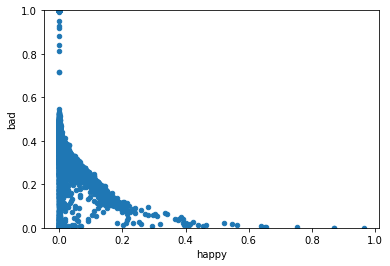

In [0]:
## Relations between bad/happy, assumption: they should be negatively correlated.
var = 'bad/happy'
data = pd.concat([df_result['bad'], df_result['happy']], axis=1)
data.plot.scatter(x='happy', y='bad', ylim=(0,1));

## The result aligns with our assumption.

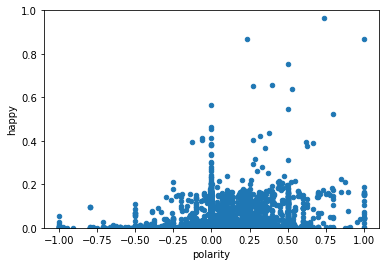

In [0]:
## Relations between polarity and happy, assumption: they should be positvely correlated.
var = 'polarity/happy'
data = pd.concat([df_result['polarity'], df_result['happy']], axis=1)
data.plot.scatter(x='polarity', y='happy', ylim=(0,1));

## We found that as the polarity grows, especially in $[0,1]$, there are more sentences classified as happy.

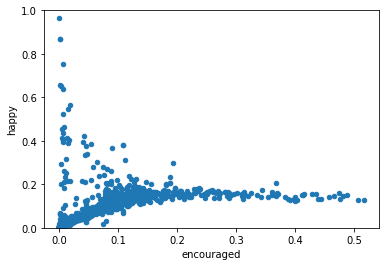

In [0]:
## Relations between encouraged and happy, assumption: they should be positvely correlated.
var = 'encouraged/happy'
data = pd.concat([df_result['encouraged'], df_result['happy']], axis=1)
data.plot.scatter(x='encouraged', y='happy', ylim=(0,1));

## Data Visualization

In this section, we will visualze the emotional changes across the time. In this notebook, it is hard to demonstrate the whole dataset, and we will only illustrate the sample dataset. The same technique can be used directly for the whole dataset.

We will first resample the data, by finding the mean value of different emotions, polarity and subjectivity in every minute. And then we will also find the sum of insult speeches in every minute. We can interpret the resampled data as:

* Average emotions, polarity and subjectivity per minute.
* Total insult speeches per minute.




In [0]:
# Resample data
## Count insult tweets by minute
df_insult = df_result.resample('T').sum()
df_result = df_result.resample('T').mean()

In [0]:
# Line gragh of different emotions
import plotly.graph_objects as go 
fig = go.Figure() 
fig.add_trace(go.Scatter(x=df_result.index, y=df_result['polarity'], 
                         mode='lines', 
                         name='Polarity', 
                         line=dict(color='#268785'))) 
fig.add_trace(go.Scatter(x=df_result.index, y=df_result['bad'], 
                         mode='lines', 
                         name='Bad', 
                         line=dict(color='#26453D'))) 
fig.add_trace(go.Scatter(x=df_result.index, y=df_result['depressed'], 
                         mode='lines', 
                         name='Depressed', 
                         line=dict(color='#005CAF'))) 
fig.add_trace(go.Scatter(x=df_result.index, y=df_result['encouraged'], 
                         mode='lines', 
                         name='Encouraged', 
                         line=dict(color='#FFB11B'))) 
fig.add_trace(go.Scatter(x=df_result.index, y=df_result['happy'], 
                         mode='lines', 
                         name='Happy', 
                         line=dict(color='#B5495B'))) 
fig.add_trace(go.Scatter(x=df_result.index, y=df_result['joy'], 
                         mode='lines', 
                         name='Joy', 
                         line=dict(color='yellow'))) 
fig.add_trace(go.Scatter(x=df_result.index, y=df_result['loving'], 
                         mode='lines', 
                         name='Loving', 
                         line=dict(color='#E03C8A')))
fig.show()

In [0]:
# Statistics of insulat tweets per minute
#df_insult.head()
fig_insult = go.Figure(data=go.Scatter(x=df_result.index, y=df_insult['is_insult']))
fig_insult.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


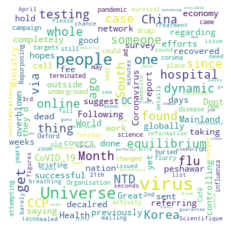

In [0]:
## Wordcloud of the tweets

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

import matplotlib.pyplot as plt
nltk.download('stopwords')

stopwords = stopwords.words('english')
new_stopwords = ['twitter','utm_campaign','bit','bit.ly','Covid','pic','utm_source','utm_social','utm_medium','https','http','COVID','html','instagram','covid','covid19']
stopwords.extend(new_stopwords)
# stopwords=load_stopwords(stopwords)
stopwords = set(stopwords)

def generate_worldcloud(texts):
  # iterate through the csv file

  wordcloud = WordCloud(width = 300, height = 300,
                  background_color ='white',
                  max_words=2048,
                  stopwords=stopwords,
                  max_font_size=25).generate(texts)
  return wordcloud
texts = " ".join(str(text) for text in df_result['tweet'] if not any(x in str(text) for x in new_stopwords))
wordcloud = generate_worldcloud(texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Warehousing

After the sentiment analysis and generating wordcloud, our program will upload the image of that wordcloud, along with the emotion data to data warehouse, so that our frontend visualizer can read the data, draw the line graph and render the background. We store the data to two different endpoints:

* **OSF(Open Science Foundation)**. They provide an easy-to-use API for quering files in the storage. We store all the wordcloud images in OSF, so that our frontend will be able to know which date is available in our dataset without loading the whole dataset. On top of that, we build a Cloud Function hosted on Google Cloud Platform to avoid cross-origin issues.

* **GitHub**. We use GitHub to provide all ```.csv``` file, i.e. the emotion data per day. It will be named with the same name in the image data, and our frontend will read the data when needed. You can find all the data at https://github.com/xzyaoi/covid-sentiment/tree/master/data

## Conclusion and Discussion

In this project, we crawled nearly 10 million Twitter data. We investigate how we can build our pipeline to analyse these tweets, visualize the results, store them properly. We build three analysers using different techniques, and **extract** the polarity, subjectivity, 6 emotions and if they are insulting others. We also drawn a wordcloud per day to show what people are caring about. We then **transform** the emotion data per minute to compute the average emotion metrics and number of insult tweets. After that we **load** the data into data warehouse. To conclude, we build a ETL system that analyses twitter data everyday.

To our surprise, we found that people's emotion are pretty stable during the pandemic. Overall, there appear more encouraging and happy tweets in May and June, compared with April. Another finding is that the insulting tweets are only a few (in our sample, 24/5352=0.4%).


## Implementation, Limitations and Possible Improvements.

Aside of this notebook, we implemented the system into a 4-nodes cluster. They can be categorized into two types:

* **Crawler**: We have a single node for crawling, hosted on Google Cloud Platform. We set a crontab on 3:00 AM every day to start the crawling for yesterday's data.

* **Analyser**: Other nodes are hosted on a Chinese provider. We want to balance our requests to every node so that we can improve the performance. To achieve so, we made the sentiment analyser and insultation detector to be HTTP service, and then we deployed HAProxy as load balancer. By doing so, we can distribute the tweet across different nodes and parallelize the process.

Even though we tried our best to parallelize the analysis part, it still takes a longer time than we expected and we cannot finish the insultation analysis on time. Thus, in the online version, we only leave the emotion and polarity analysis there. However, if possible we can purchase more nodes, and deploy the insultation detector and finish the insultation analysis.

Another problem in our analysis is that we have not considered other keywords to search. It might be useful and interesting to look into other keywords, such as #China, #Trump to compare people's emotion changes.


